In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

<h3><font color = "#079e05"> Utilities </font></h3>

In [3]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

In [5]:
cards = [cv2.imread(f'pics/cr_{i}.jpg') for i in range(1, 7)]
ids = [cv2.imread(f'pics/id_{i}.jpg') for i in range(1, 4)]
others = [cv2.imread(f'pics/oth_{i}.jpg') for i in range(1, 5)]
pics = cards + ids + others

In [6]:
def show(im, sh):
    if sh:
        imshow(im)
    

def make_gray(im, sh=False):
    result = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    show(result, sh)
    return result

def make_clahe(grayim, clipLimit, tileGridSize, sh=False):
    grayim = grayim.copy()
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    res = clahe.apply(grayim)
    show(res, sh)
    return grayim

def make_blur(im, size, eps, sh=False):
    res = cv2.GaussianBlur(im,size,eps)
    show(res, sh)
    return res

def make_median(im, size, sh=False):
    res =cv2.medianBlur(im,size)
    show(res, sh) 
    return res

def make_thresh(im, size, c, sh=False):
    # ret2, otsuim = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, size, c)
    show(thresh, sh)
    return thresh

def make_morph(im, size, sh=False):
    # k1 = np.ones((2, 2), np.uint8)
    k2 = np.ones(size, np.uint8)
    # im = cv2.dilate(im, k1, iterations=1)
    res = cv2.erode(im, k2, iterations=1)
    show(res, sh)
    return res

def make_canny(im, sh=False):
    res = cv2.Canny(im, 125, 255)
    show(res, sh)
    return res

def draw_hough(im, lines):
    img = im.copy()
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img

def draw_contours(im, cnts):
    im = im.copy()
    cv2.drawContours(im, cnts, -1, (0,255,0), 3)
    return im

def make_contours(im, sh=False):
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    papercontour = contours[0]
    for con in contours:
        if cv2.contourArea(con) > cv2.contourArea(papercontour): # paper border is the largest contour
            papercontour = con

    contours = list(contours)
    contours.sort(key=lambda cnt: -cv2.contourArea(cnt))

    hulls = [cv2.convexHull(cnt) for cnt in contours]
    hulls.sort(key=lambda cnt: -cv2.contourArea(cnt))
    show(draw_contours(im, hulls), sh)
    return hulls

def make_corners(cnt):
    epsilon = 0.03 * cv2.arcLength(cnt, True)
    corners = cv2.approxPolyDP(cnt, epsilon, True)[::, 0, ::]
    return corners
    
def sort_corners(cnrs):
    sorted_points = sorted(cnrs, key=lambda x : x[0])

    left_points = sorted_points[0:2]
    top_left = left_points[0] if left_points[0][1] < left_points[1][1] else left_points[1]
    btm_left = left_points[0] if left_points[0][1] > left_points[1][1] else left_points[1]

    right_points = sorted_points[2:4]
    top_right = right_points[0] if right_points[0][1] < right_points[1][1] else right_points[1]
    btm_right = right_points[0] if right_points[0][1] > right_points[1][1] else right_points[1]

    return np.array([[top_left], [top_right], [btm_left], [btm_right]], dtype=np.float32)

def make_prespective(im, srcp, width, height, sh=False):
    dx, dy = 0, 0
    dstp = np.array([[[0+dx, 0+dy]], [[width-dx, 0+dy]], [[0+dx, height-dy]], [[width-dx, height-dy]]], dtype=np.float32)
    mat = cv2.getPerspectiveTransform(srcp, dstp)
    res = cv2.warpPerspective(im, mat, (width, height))
    show(res, sh)
    return res



In [15]:
average_config = {'resize':(1280, 960),
          'clahe':{'limit':2.0, 'size':(8,8)},
          'blur':{'size':(15,15), 'eps':11},
          'median':5,
          'thresh':{'size':35, 'c':2},
          'morph': (5,5),
          'outsize':(512,328)}

high_contrast_config = {'resize':(1280, 960),
          'clahe':{'limit':2.0, 'size':(8,8)},
          'blur':{'size':(15,15), 'eps':11},
          'median':5,
          'thresh':{'size':31, 'c':3},
          'morph': (5,5),
          'outsize':(512,328)}

low_contrast_config = {'resize':(1280, 960),
          'clahe':{'limit':2.0, 'size':(8,8)},
          'blur':{'size':(5,5), 'eps':5},
          'median':5,
          'thresh':{'size':31, 'c':3},
          'morph': (5,5),
          'outsize':(512,328)}

def cut_card(im, config):
    im = cv2.resize(im, config['resize'])
    original = im.copy()
    
    im = make_gray(im, False)
    im = make_clahe(im , config['clahe']['limit'], config['clahe']['size'], False)
    im = make_blur(im, config['blur']['size'], config['blur']['eps'], False)
    # im = make_median(im, config['median'], True)
    im = make_thresh(im, config['thresh']['size'], config['thresh']['c'], False)
    im = make_morph(im, config['morph'], False)
    # edges = make_canny(im, False)
    contours = make_contours(im, True)
    corners = make_corners(contours[1])
    width, height = config['outsize']
    src_points = sort_corners(corners)
    result = make_prespective(original, src_points, width, height, False)
    return result


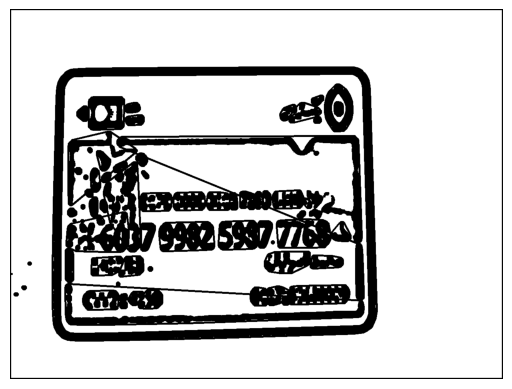

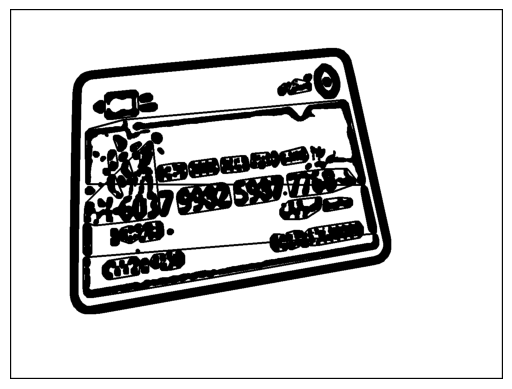

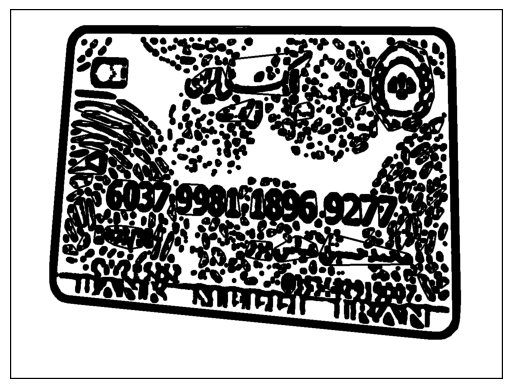

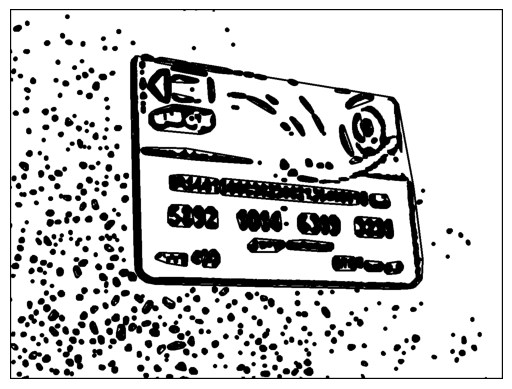

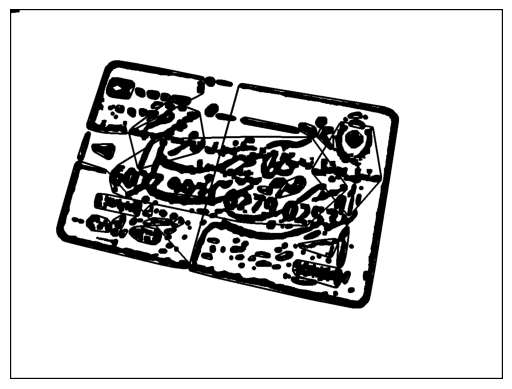

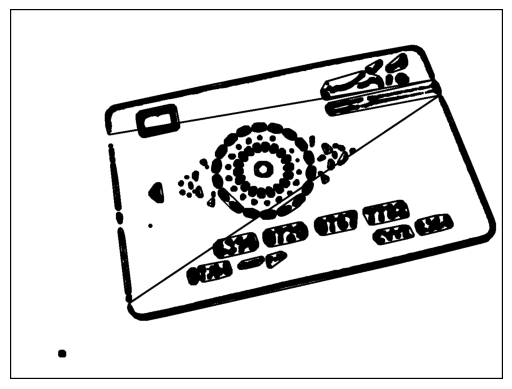

error for cr_6.jpg


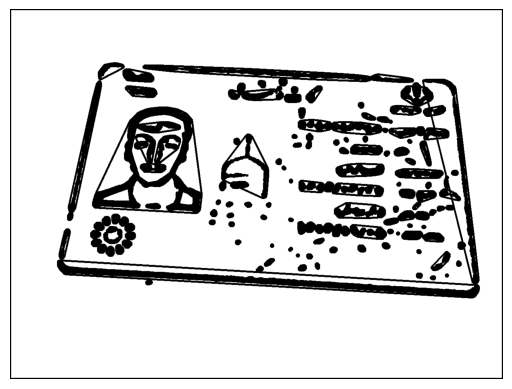

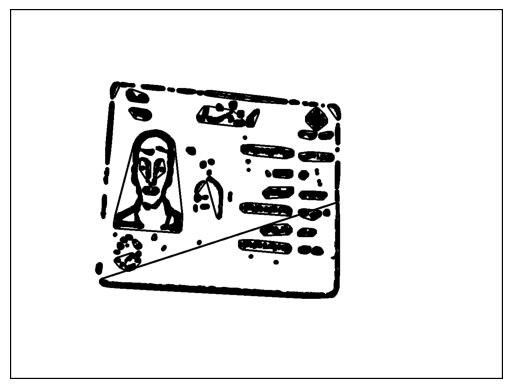

error for id_2.jpg


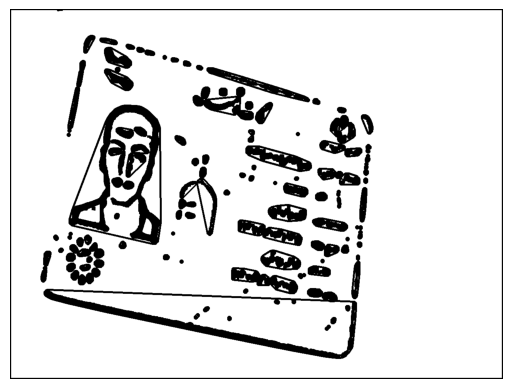

error for id_3.jpg


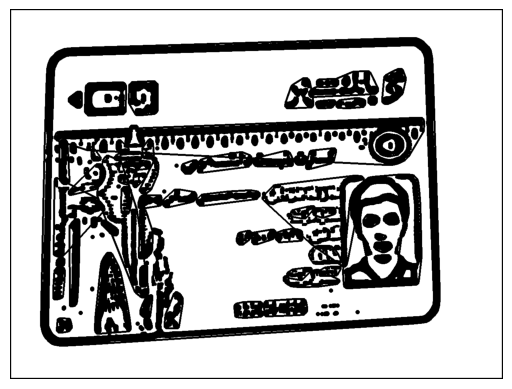

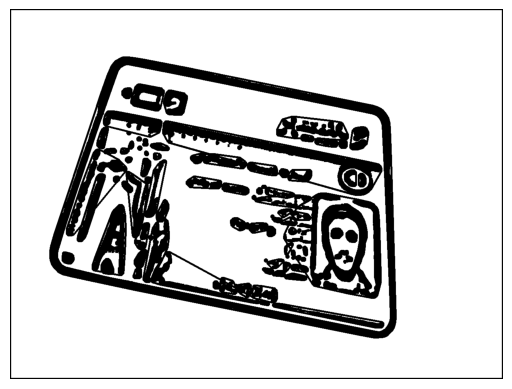

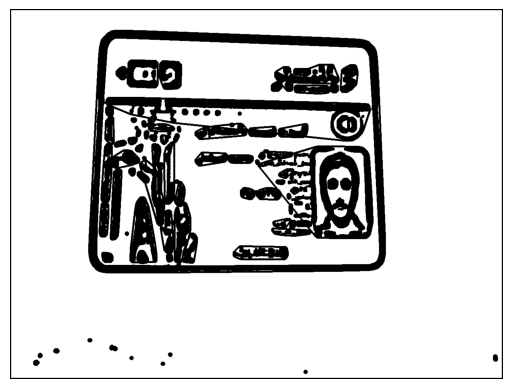

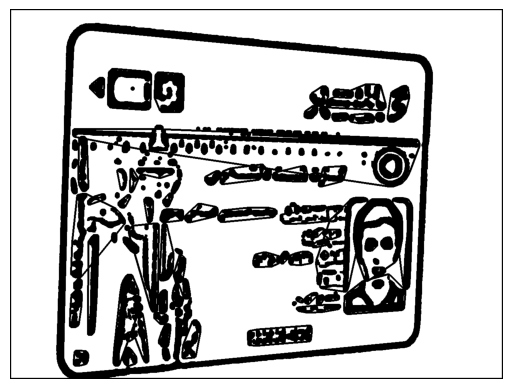

In [16]:
for path in os.listdir('pics'):
    im = cv2.imread('pics/' + path)
    try:
        cut = cut_card(im, average_config)
        cv2.imwrite('cutpics/' + path, cut)
    except:
        print('error for ' + path)